# GPflow with TF 2.0

In [1]:
import tensorflow as tf
import gpflow

import numpy as np
import matplotlib.pyplot as plt
import datetime
import io

np.random.seed(0)
tf.random.set_seed(0)

## Loading data using TensorFlow Datasets

For this example, we create a synthetic dataset (noisy sine function) 

(0, 10)

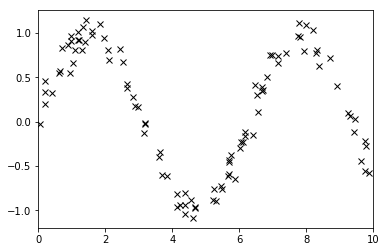

In [2]:
def noisy_sin(x): 
    return np.sin(x) + 0.1 * np.random.randn(*x.shape)

N, Ntest = 100, 500
X, Xtest = np.random.rand(N, 1) * 10, np.random.rand(Ntest, 1) * 10
Y, Ytest = noisy_sin(X), noisy_sin(Xtest)

plt.plot(X, Y, 'xk')
plt.xlim(0, 10)

Working with Tensorflow Datasets is an efficient way to rapidly shuffle, iterate and batch from data.

In [3]:
dataset = tf.data.Dataset.from_tensor_slices((X, Y))
test_dataset = tf.data.Dataset.from_tensor_slices((Xtest, Ytest))

batch_size = 32


dataset = dataset\
    .repeat(True)\
    .prefetch(10000)\
    .shuffle(buffer_size=10000)\
    .batch(batch_size)

W0620 17:38:40.404354 140003769710400 deprecation.py:323] From /home/sergio.diaz/tf2/lib/python3.6/site-packages/tensorflow_core/python/data/util/random_seed.py:58: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Define a GP model

In GPflow2.0, we use tf.Module to build all our models, as well as, their components (kernels, likelihoods, parameters, etc.). 

In [4]:
M = 10
kern = gpflow.kernels.RBF(variance=2.)
lik = gpflow.likelihoods.Gaussian()
Z = np.linspace(0, 10, M).reshape(-1, 1)

model = gpflow.models.SVGP(kernel=kern, likelihood=lik, feature=Z)

You can set a module (or a particular parameter) to be non-trainable using the auxiliary method ```set_trainable(module, False)```

In [5]:
from gpflow.utilities.training import set_trainable

set_trainable(lik, False)
set_trainable(kern.variance, False)

We can use ```param.assign(value)``` to assign a value to a parameter:

In [6]:
kern.lengthscale.assign(1.5)

All these changes are reflected when we use ```print_summary(model)``` to print a detailed summary of the model.

In [7]:
# from gpflow.utilities.printing import print_summary
# print_summary(model)

## Training using Gradient Tapes

In TensorFlow2.0, we can optimise (trainable) model parameters with Tensorflow optimizers using GradientTapes. In this simple example, we perform one gradient update of the Adam optimizer to minimize the negative marginal log likelihood (or ELBO) of our model.

In [8]:
optimizer = tf.optimizers.Adam()

with tf.GradientTape() as tape: 
    tape.watch(model.trainable_variables)
    loss = model.neg_log_marginal_likelihood(X, Y)
    grads = tape.gradient(loss, model.trainable_variables)
    
optimizer.apply_gradients(zip(grads, model.trainable_variables))

W0620 17:38:43.336522 140003769710400 deprecation.py:323] From /home/sergio.diaz/tf2/lib/python3.6/site-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:460: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1>

For a more elaborare example of a gradient update we can define an ```optimization_step``` that uses decorator ```tf.function``` on a closure. A closure is callable that returns the model objective evaluated at a given dataset when called.

In [9]:
class Closure: 
    def set_data(self, batch): 
        self.X, self.Y = batch
        
    @tf.function
    def __call__(self): 
        return model.neg_log_marginal_likelihood(self.X, self.Y)

closure = Closure()

def optimization_step(batch): 
    closure.set_data(batch)
    with tf.GradientTape() as tape: 
        tape.watch(model.trainable_variables)
        loss = closure()
        grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

We can make use the functionality of TensorFlow Datasets to define a simple training loop that iterates over batches of the training dataset: 

In [10]:
def simple_training_loop(model, batch_size, epochs: int):
    num_batches_per_epoch = int(N / batch_size)
    for epoch in range(epochs):
        batches_epoch = iter(dataset)
        for _ in range(num_batches_per_epoch):
            batch = next(batches_epoch)
            optimization_step(batch)
        if (epoch + 1) % 100 == 0: 
            print(r'Epoch %i completed: ELBO training set %f4' % (
                epoch + 1, model.neg_log_marginal_likelihood(X,Y))
                 )

In [11]:
simple_training_loop(model, batch_size=batch_size, epochs=1000)

W0620 17:38:46.466522 140003769710400 ag_logging.py:146] Entity <bound method Dispatcher.dispatch_iter of <dispatched conditional>> appears to be a generator function. It will not be converted by AutoGraph.


W0620 17:38:46.905427 140003769710400 ag_logging.py:146] Entity <bound method Dispatcher.dispatch_iter of <dispatched Kuf>> appears to be a generator function. It will not be converted by AutoGraph.


Epoch 100 completed: ELBO training set 135.8124784
Epoch 200 completed: ELBO training set 114.5467354
Epoch 300 completed: ELBO training set 109.3089614
Epoch 400 completed: ELBO training set 107.8008884
Epoch 500 completed: ELBO training set 107.3097194
Epoch 600 completed: ELBO training set 107.1252364
Epoch 700 completed: ELBO training set 107.0467544
Epoch 800 completed: ELBO training set 107.0117884
Epoch 900 completed: ELBO training set 106.9966414
Epoch 1000 completed: ELBO training set 106.9903464


## Monitoring 

We can monitor the training procedure using TensorFlow summary. First we create a summary writer object under which we can write scalar and images.

In [13]:
from plotting_regression import plotting_regression

def summary_matplotlib_image(figures, step, fmt='png'):
    for name, fig in figures.items():
        buf = io.BytesIO()
        fig.savefig(buf, format=fmt, bbox_inches='tight')
        buf.seek(0)
        image = tf.image.decode_image(buf.getvalue(), channels=4)
        image = tf.expand_dims(image, 0)
        img_summary = tf.summary.image(name=name, data=image, step=step)

def monitored_training_loop(model, batch_size: int, epochs: int, log_dir: str):
    summary_writer = tf.summary.create_file_writer(log_dir)
    num_batches_per_epoch = int(N / batch_size)
    for epoch in range(epochs):
        batches_epoch = iter(dataset)
        for _ in range(num_batches_per_epoch):
            batch = next(batches_epoch)
            optimization_step(batch)

        with summary_writer.as_default():
            tf.summary.scalar('loss', data=model.neg_log_marginal_likelihood(X,Y), step=epoch)
            tf.summary.scalar('lik.variance', data=model.likelihood.variance, step=epoch)
            tf.summary.scalar('kern.ls', data=model.kernel.lengthscale, step=epoch)
            tf.summary.scalar('kern.variance', data=model.kernel.variance, step=epoch)
            
        if (epoch + 1) % 100 == 0: 
            print(r'Epoch %i completed: ELBO training set %f4' % (
                epoch + 1, model.neg_log_marginal_likelihood(X,Y))
                 )    
            xx = np.linspace(0, 10, 100).reshape(100, 1) 
            mean, var = model.predict_f(xx)
            samples = model.predict_f_samples(xx, 10)

            fig = plotting_regression(X, Y, xx, mean, var, samples)
            
            with summary_writer.as_default():
                summary_matplotlib_image({'samples from model' : fig}, step=epoch)

In [14]:
model = gpflow.models.SVGP(kernel=kern, likelihood=lik, feature=Z)
closure = Closure()

log_dir = '/tmp/logs/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
print(r'Logs folder path: %s' % (log_dir))

monitored_training_loop(model, batch_size=batch_size, epochs=1000, log_dir=log_dir)

Logs folder path: /tmp/logs/20190620-173907
Epoch 100 completed: ELBO training set 108.3828024
Epoch 200 completed: ELBO training set 107.1631734
Epoch 300 completed: ELBO training set 107.0229314
Epoch 400 completed: ELBO training set 106.9902964
Epoch 500 completed: ELBO training set 106.9803234
Epoch 600 completed: ELBO training set 106.9770144
Epoch 700 completed: ELBO training set 106.9758394
Epoch 800 completed: ELBO training set 106.9753404
Epoch 900 completed: ELBO training set 106.9750464
Epoch 1000 completed: ELBO training set 106.9748014


<Figure size 432x288 with 0 Axes>

Then, we can then use Tensorboard to examine the training procedure more in detail.

In [15]:
# ! tensorboard --logdir <log directory path>

## Checkpointing: saving and loading models

With the help of `tf.train.CheckpointManager` and `tf.train.Checkpoint`, we can checkpoint the model throughout the training procedure. Let's start with a simple example using checkpointing to save and load `tf.Variables`:

In [16]:
a = tf.Variable(1.2)
# Create Checkpoint object
checkpoint_obj = tf.train.Checkpoint(a=a)
checkpoint_path = '/tmp/simple_example/' + datetime.datetime.now().strftime("%Y%m%d-%H%M")
manager = tf.train.CheckpointManager(checkpoint_obj, checkpoint_path, max_to_keep=10) 
# Save variable
manager.save()
a.assign(0.33)
print('Current value of variable a: %f' % (a.numpy()))
checkpoint_obj.restore(manager.latest_checkpoint)
print('Value of variable a: %f' % (a.numpy()))

Current value of variable a: 0.330000
Value of variable a: 1.200000


In this example bellow, we modify a simple training loop to save the model every 100 epochs using the CheckpointManager.

In [17]:
model = gpflow.models.SVGP(kernel=kern, likelihood=lik, feature=Z)
closure = Closure()

def checkpointing_training_loop(model, batch_size: int, epochs: int, manager: tf.train.CheckpointManager):
    num_batches_per_epoch = int(N / batch_size)
    for epoch in range(epochs):
        batches_epoch = iter(dataset)
        for _ in range(num_batches_per_epoch):
            batch = next(batches_epoch)
            optimization_step(batch)
        if (epoch + 1) % 100 == 0: 
            ckpt_path = manager.save()
            print(r'Epoch %i completed: ELBO training set %f3, model checkpointing saved at %s' % (
                epoch + 1, model.neg_log_marginal_likelihood(X,Y), ckpt_path)
                 )

In [19]:
ckpt = tf.train.Checkpoint(model=model)
checkpoint_path = '/tmp/tf_ckpts/' + datetime.datetime.now().strftime("%Y%m%d-%H%M")

manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=10)         
print(r'Checkpoint folder path at: %s' % (checkpoint_path))

checkpointing_training_loop(model, batch_size=batch_size, epochs=1000, manager=manager)

Checkpoint folder path at: /tmp/tf_ckpts/20190620-1739
Epoch 100 completed: ELBO training set 108.2411683, model checkpointing saved at /tmp/tf_ckpts/20190620-1739/ckpt-1
Epoch 200 completed: ELBO training set 107.1402743, model checkpointing saved at /tmp/tf_ckpts/20190620-1739/ckpt-2
Epoch 300 completed: ELBO training set 107.0170233, model checkpointing saved at /tmp/tf_ckpts/20190620-1739/ckpt-3
Epoch 400 completed: ELBO training set 106.9882623, model checkpointing saved at /tmp/tf_ckpts/20190620-1739/ckpt-4
Epoch 500 completed: ELBO training set 106.9795233, model checkpointing saved at /tmp/tf_ckpts/20190620-1739/ckpt-5
Epoch 600 completed: ELBO training set 106.9766403, model checkpointing saved at /tmp/tf_ckpts/20190620-1739/ckpt-6
Epoch 700 completed: ELBO training set 106.9756183, model checkpointing saved at /tmp/tf_ckpts/20190620-1739/ckpt-7
Epoch 800 completed: ELBO training set 106.9751813, model checkpointing saved at /tmp/tf_ckpts/20190620-1739/ckpt-8
Epoch 900 complet

Once the models have been saved, we can resore them using ```tf.train.Checkpoint.restore``` and assert their performance corresponds to the logs during training.

In [20]:
for i, recorded_checkpoint in enumerate(manager.checkpoints): 
    ckpt.restore(recorded_checkpoint)
    print(r'Restored model from epoch %i : ELBO training set %f3' % (
        i + 1, model.neg_log_marginal_likelihood(X,Y))
         )

Restored model from epoch 1 : ELBO training set 108.2411683
Restored model from epoch 2 : ELBO training set 107.1402743
Restored model from epoch 3 : ELBO training set 107.0170233
Restored model from epoch 4 : ELBO training set 106.9882623
Restored model from epoch 5 : ELBO training set 106.9795233
Restored model from epoch 6 : ELBO training set 106.9766403
Restored model from epoch 7 : ELBO training set 106.9756183
Restored model from epoch 8 : ELBO training set 106.9751813
Restored model from epoch 9 : ELBO training set 106.9749173
Restored model from epoch 10 : ELBO training set 106.9746913
